# Mount drive

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

# !ls /content/gdrive/My\ Drive

In [ ]:
# !unzip /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319/hw1_data.zip -d /content/gdrive/MyDrive/Q56094077/snrs/hw1_0319

# Import Library

In [1]:
import os

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import json

from tqdm import tqdm
from datetime import datetime
import time
import matplotlib.pyplot as plt

In [2]:
import networkit as nk
import networkx as nx

In [3]:
import drbc
import utils
import utils.data
import utils.eval

# Setting

In [4]:
class Setting:
    _root = os.getcwd()

    _data = os.path.join(_root, "hw1_data")

    data_synthetic = os.path.join(_data, "Synthetic", "5000")
    
    data_youtube = os.path.join(_data, "Real", "youtube")
    data_amazon = os.path.join(_data, "Real", "amazon")
    data_dblp = os.path.join(_data, "Real", "dblp")
    data_comlj = os.path.join(_data, "Real", "com-lj")
    
    data_train = os.path.join(_data, "train")
    data_valid = os.path.join(_data, "valid")
    
    ### Data split
    data_split = os.path.join(_root, "split.json")
    

    # Setting of training
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

    epochs = 100
    nodes_cnt = 200
    
    params_drbc = dict(
        # according to source paper
        encoder_params = dict(
            c = 3,
            p = 128,
            num_layers = 5,
            device = device
        ),
        decoder_params = dict(
            p = 128,
            q = 64
        )
    )

    params_node2vec = dict(
        in_features = 128
    )
    
    
    
    def __init__(self, date_time=None):
        
    
        # Create dir for train/test
        self.root = os.path.join(self._root, "result", date_time)
        if os.path.exists(self.root):
            pass
        else:
            os.makedirs(self.root)


        ### Save plt info
        self.train_info_p = os.path.join(self.root, "train.json")
        self.val_info_p = os.path.join(self.root, "valid.json")

        ### Save plt img
        self.result_plt_p = os.path.join(self.root, "train_plt.png")
    
        self.weight_drbc = os.path.join(self.root, "drbc.pth")
    

In [5]:
# date_time = datetime.strftime(datetime.now(), "%Y-%m-%d %H-%M")
date_time = "2021-03-24 08-48"

In [6]:
setting = Setting(date_time=date_time)

setting.root

'/home/ai2019/ne6081064/june/mlg/snrs_hw1/result/2021-03-24 08-48'

# Data

- data.x	节点特征，维度是[num_nodes, num_node_features]。
- data.edge_index	维度是[2, num_edges]，描述图中节点的关联关系，每一列对应的两个元素，分别是边的起点和重点。数据类型是torch.long。需要注意的是，data.edge_index是定义边的节点的张量（tensor），而不是节点的列表（list）。
- data.edge_attr	边的特征矩阵，维度是[num_edges, num_edge_features]
- data.y	训练目标（维度可以是任意的）。对于节点相关的任务，维度为[num_nodes, *]；对于图相关的任务，维度为[1,*]。
- data.position	节点位置矩阵（Node position matrix），维度为[num_nodes, num_dimensions]。

- [Learning to Identify High Betweenness Centrality Nodes from
Scratch: A Novel Graph Neural Network Approach](https://arxiv.org/pdf/1905.10418.pdf)
- node initial feature = [$(d_v), 1, 1]

## Read data

### Load test data

In [7]:
syn, syn_score = utils.data.load_data(Setting.data_synthetic, mode="closeness")

In [8]:
train, train_score = utils.data.load_data(os.path.join(Setting.data_train, str(Setting.nodes_cnt)), mode="closeness")

In [9]:
valid, valid_score = utils.data.load_data(os.path.join(Setting.data_valid, str(Setting.nodes_cnt)), mode="closeness")

### Cvt to data/dataloader

In [10]:
train_loader = utils.data.to_dataloader(train, train_score, batch=2, usecols=0)
valid_loader = utils.data.to_dataloader(valid, valid_score, batch=2, usecols=0)

In [11]:
syn_loader = utils.data.to_dataloader(syn, syn_score, batch=1, usecols=0)

# Model

In [12]:
model, optimizer = drbc.load_checkpoint(
                    setting.weight_drbc,
                    Setting.device,
                    drbc = Setting.params_drbc)

model

pretrained finded


DrBC(
  (encoder): Encoder(
    (w_0): Linear(in_features=3, out_features=128, bias=True)
    (relu): ReLU(inplace=True)
    (rnn): GRUCell(128, 128)
  )
  (decoder): Decoder(
    (w_4): Linear(in_features=128, out_features=64, bias=True)
    (w_5): Linear(in_features=64, out_features=1, bias=True)
    (relu): ReLU(inplace=True)
  )
)

## DrBC

In [ ]:
nodes_cnt = setting.nodes_cnt


model.train()

train_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

valid_info = {
    "bce": [],
    "top1": [],
    "top5": [],
    "top10": [],
    "kendal": []
}

top_10 = 0.0
top_5 = 0.0
top_1 = 0.0

for epoch in range(setting.epochs):


    print("\nEpoch: {}".format(epoch+1))

    for batch in tqdm(train_loader):
    
        ### Start training
        optimizer.zero_grad()
        batch = batch.to(setting.device)

        bc_pr = model(batch)
    
        
        # compute batch loss
        b_index = batch.batch.cpu().numpy()
        b = np.max(b_index) + 1
        
        batch_loss = torch.tensor(0, dtype=torch.float).to(setting.device)
        
        for b_ in range(b):
            
            indice, = np.where(b_index == b_)
            
            gt = batch.y[indice].squeeze()
            pr = bc_pr[indice].squeeze()
            
            # random sample 5|V| nodes
            src = np.random.choice(len(indice), 5*len(indice), replace=True)
            det = np.random.choice(len(indice), 5*len(indice), replace=True)
            src = torch.from_numpy(src)
            det = torch.from_numpy(det)

            
            y_gt = gt[det] - gt[src]
            y_pr = pr[det] - pr[src]
            
            y_gt = nn.Sigmoid()(y_gt)
            y_pr = nn.Sigmoid()(y_pr)
        
            batch_loss += nn.BCELoss()(y_pr, y_gt)
        
        batch_loss = torch.div(batch_loss, b)
        batch_loss.backward()
        optimizer.step()
    
    
    ### Evaluation
    with torch.no_grad():
        
        
        top1_list = []
        top5_list = []
        top10_list = []
        kendal_list = []
        loss_list = []
        
        for batch in tqdm(train_loader):

            batch = batch.to(setting.device)

            bc_pr = model(batch)

            b_index = batch.batch.cpu().numpy()
            b = np.max(b_index) + 1

            for b_ in range(b):

                indice, = np.where(b_index == b_)

                gt = batch.y[indice].squeeze()
                pr = bc_pr[indice].squeeze()
                
                # evaluation
                top1 = top_n_percentage(gt, pr, k=1)
                top5 = top_n_percentage(gt, pr, k=5)
                top10 = top_n_percentage(gt, pr, k=10)
                kendal = kendal_tau_distance(gt, pr)
                

                # compute loss
                src = np.random.choice(len(indice), 5*len(indice), replace=True)
                det = np.random.choice(len(indice), 5*len(indice), replace=True)
                src = torch.from_numpy(src)
                det = torch.from_numpy(det)

                y_gt = gt[det] - gt[src]
                y_pr = pr[det] - pr[src]

                y_gt = nn.Sigmoid()(y_gt)
                y_pr = nn.Sigmoid()(y_pr)

                loss = nn.BCELoss()(y_pr, y_gt)
                
                top1_list.append(top1)
                top5_list.append(top5)
                top10_list.append(top10)
                kendal_list.append(kendal)
                loss_list.append(loss.item())
                

        bce = sum(loss_list)/len(loss_list)
        top1 = sum(top1_list)/len(top1_list)
        top5 = sum(top5_list)/len(top5_list)
        top10 = sum(top10_list)/len(top10_list)
        kendal = sum(kendal_list)/len(kendal_list)      
        
                
        print("Train: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                bce,
                top1,
                top5,
                top10,
                kendal
        ))

        train_info["bce"].append(bce)
        train_info["top1"].append(top1)
        train_info["top5"].append(top5)
        train_info["top10"].append(top10)
        train_info["kendal"].append(kendal)

        with open(setting.train_info_p, 'w') as f:
            json.dump(train_info, f)
            
            
    
        top1_list = []
        top5_list = []
        top10_list = []
        kendal_list = []
        loss_list = []
        
        for batch in tqdm(valid_loader):

            batch = batch.to(setting.device)

            bc_pr = model(batch)

            b_index = batch.batch.cpu().numpy()
            b = np.max(b_index) + 1

            for b_ in range(b):

                indice, = np.where(b_index == b_)
            

                gt = batch.y[indice].squeeze()
                pr = bc_pr[indice].squeeze()
                
                # evaluation
                top1 = top_n_percentage(gt, pr, k=1)
                top5 = top_n_percentage(gt, pr, k=5)
                top10 = top_n_percentage(gt, pr, k=10)
                kendal = kendal_tau_distance(gt, pr)

                # compute loss
                src = np.random.choice(len(indice), 5*len(indice), replace=True)
                det = np.random.choice(len(indice), 5*len(indice), replace=True)
                src = torch.from_numpy(src)
                det = torch.from_numpy(det)

                y_gt = gt[det] - gt[src]
                y_pr = pr[det] - pr[src]

                y_gt = nn.Sigmoid()(y_gt)
                y_pr = nn.Sigmoid()(y_pr)

                loss = nn.BCELoss()(y_pr, y_gt)
                
                top1_list.append(top1)
                top5_list.append(top5)
                top10_list.append(top10)
                kendal_list.append(kendal)
                loss_list.append(loss.item())
                

        bce = sum(loss_list)/len(loss_list)
        top1 = sum(top1_list)/len(top1_list)
        top5 = sum(top5_list)/len(top5_list)
        top10 = sum(top10_list)/len(top10_list)
        kendal = sum(kendal_list)/len(kendal_list)      
        
                
        print("Valid: loss = {}, top 1 = {}, top 5 = {}, top 10 = {}, kendal = {}".format(
                bce,
                top1,
                top5,
                top10,
                kendal
        ))

        valid_info["bce"].append(bce)
        valid_info["top1"].append(top1)
        valid_info["top5"].append(top5)
        valid_info["top10"].append(top10)
        valid_info["kendal"].append(kendal)

        with open(setting.val_info_p, 'w') as f:
            json.dump(valid_info, f)



        if top10 > top_10:
            checkpoint = {
                'model_stat': model.state_dict(),
                'optimizer_stat': optimizer.state_dict(),
            }
            top_10 = top10
            
            torch.save(checkpoint, setting.weight_drbc)

### Evaluate

In [14]:
top1_list, top5_list, top10_list, kendal_list, time_list, loss_list = utils.eval.eval_model(model, syn_loader, "cpu")

top1_list = np.array(top1_list)
top5_list = np.array(top5_list)
top10_list = np.array(top10_list)
kendal_list = np.array(kendal_list)
time_list = np.array(time_list)
loss_list = np.array(loss_list)


print("Top1: mean={:.2f}, std={:.2f}".format(np.mean(top1_list), np.std(top1_list)))
print("Top5: mean={:.2f}, std={:.2f}".format(np.mean(top5_list), np.std(top5_list)))
print("Top10: mean={:.2f}, std={:.2f}".format(np.mean(top10_list), np.std(top10_list)))
print("Kendal: mean={:.2f}, std={:.2f}".format(np.mean(kendal_list), np.std(kendal_list)))
print("Time: mean={:.2f}, std={:.2f}".format(np.mean(time_list), np.std(time_list)))
print("Loss: mean={:.2f}, std={:.2f}".format(np.mean(loss_list), np.std(loss_list)))


with open(os.path.join(setting.root, "drbc_{}.json".format(setting.nodes_cnt)), 'w') as f:
    json.dump({
        "top1": list(top1_list),
        "top5": list(top5_list),
        "top10": list(top10_list),
        "kendal": list(kendal_list),
        "time": list(time_list)
    }, f)

100%|██████████| 30/30 [00:11<00:00,  2.56it/s]

Top1: mean=0.83, std=0.05
Top5: mean=0.69, std=0.05
Top10: mean=0.66, std=0.06
Kendal: mean=0.76, std=0.02
Time: mean=0.38, std=0.02
Loss: mean=0.69, std=0.00


# Visualization

In [13]:
setting.root

'/home/ai2019/ne6081064/june/mlg/snrs_hw1/result/2021-03-24 08-48'

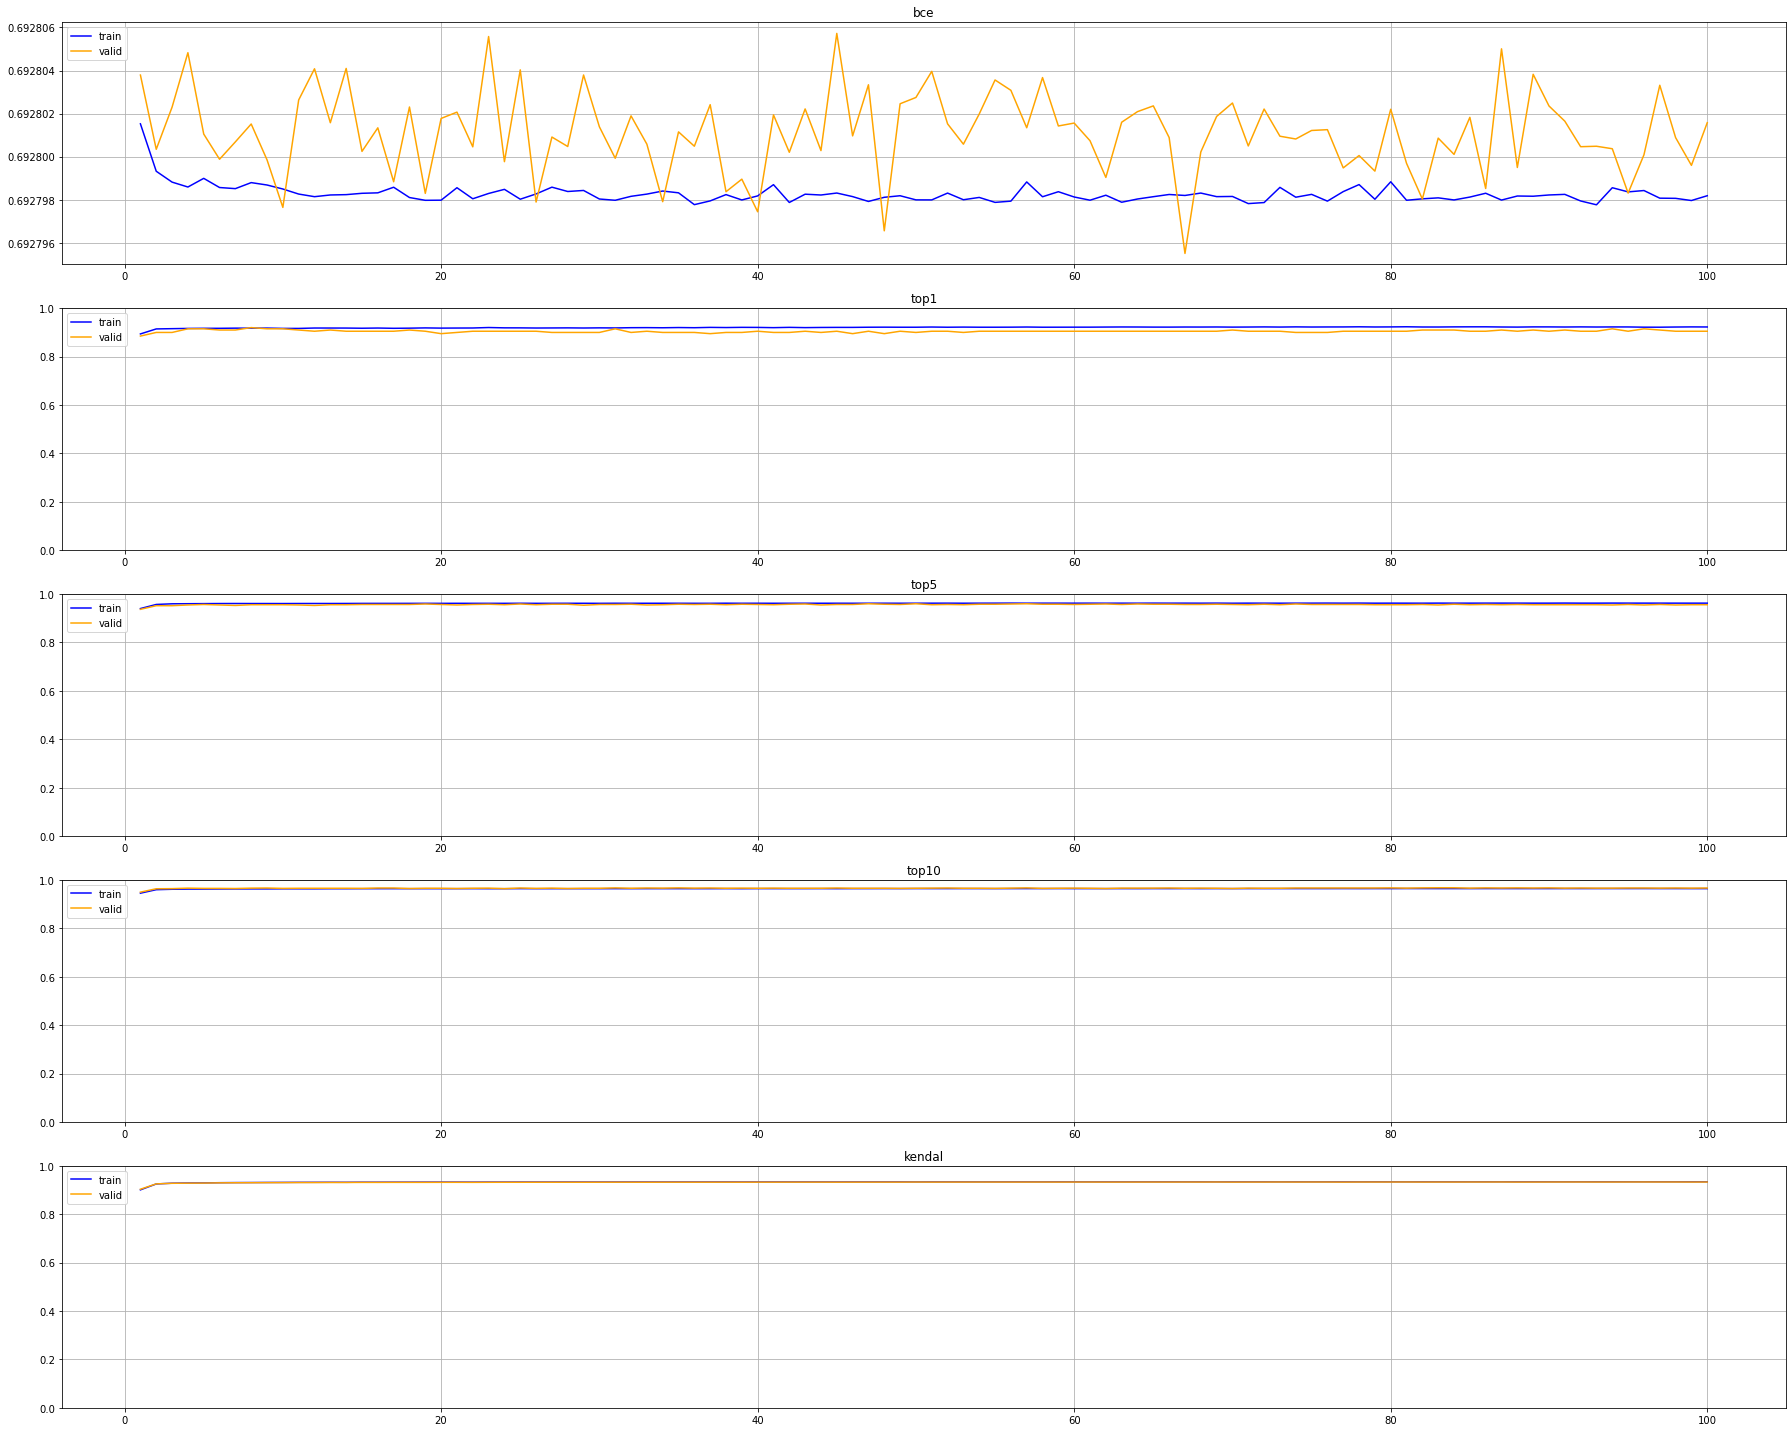

In [14]:
drbc.visualize_plt(setting.train_info_p, setting.val_info_p, setting.result_plt_p)

# Compare diff scale

In [ ]:
weights = os.path.join(setting._root, "weights")

for weight_f in os.listdir(weights):
    print("weight: {}".format(weight_f))
    
    model, _ = load_checkpoint(
                    os.path.join(weights, weight_f),
                    "cpu",
                    drbc = setting.params_drbc,
                    node2vec = setting.params_node2vec)
    model.eval()
    
    basename = os.path.splitext(weight_f)[0]
    with open(os.path.join(setting._root, "{}.json".format(basename)), "w") as f:
        jsn = {
            "top1": [],
            "top5": [],
            "top10": [],
            "kendal": [],
            "time": []
        }

        for edge_list, score in zip(synthetic, between):

            data = to_data(edge_list, score)

            start = time.time()
            bc_pr = model(data)
            end = time.time()

            bc_gt = np.array(data.y)


            jsn["time"].append(end-start)
            jsn["kendal"].append(kendal_tau_distance(bc_pr, bc_gt))
            jsn["top1"].append(top_n_percentage(bc_pr, bc_gt, k=1))
            jsn["top5"].append(top_n_percentage(bc_pr, bc_gt, k=5))
            jsn["top10"].append(top_n_percentage(bc_pr, bc_gt, k=10))

        json.dump(jsn, f)
    

In [ ]:
with open(os.path.join(setting._root, "result", "comparison", "200.json"), "r") as f_200, \
    open(os.path.join(setting._root, "result", "comparison", "300.json"), "r") as f_300, \
    open(os.path.join(setting._root, "result", "comparison", "1200.json"), "r") as f_1200, \
    open(os.path.join(setting._root, "result", "comparison", "3000.json"), "r") as f_3000, \
    open(os.path.join(setting._root, "result", "comparison", "5000.json"), "r") as f_5000 :
    
    r_200 = json.load(f_200)
    r_300 = json.load(f_300)
    r_1200 = json.load(f_1200)
    r_3000 = json.load(f_3000)
    r_5000 = json.load(f_5000)

    keys = list(r_200.keys())
    
    fig, axs = plt.subplots(len(keys), figsize=(25, 4*len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        ax.boxplot([r_200[key], r_300[key], r_1200[key], r_3000[key], r_5000[key]], widths=0.5)
        ax.set_title(key)
        ax.grid()
        
        print("\n{}".format(key))
        ### Calculate mean and std
        r_200_ = np.array(r_200[key])
        print("scale=200, mean={}, std={}".format(np.mean(r_200_), np.std(r_200_)))
        
        r_300_ = np.array(r_300[key])
        print("scale=300, mean={}, std={}".format(np.mean(r_300_), np.std(r_300_)))
        
        r_1200_ = np.array(r_1200[key])
        print("scale=1200, mean={}, std={}".format(np.mean(r_1200_), np.std(r_1200_)))
        
        r_3000_ = np.array(r_3000[key])
        print("scale=3000, mean={}, std={}".format(np.mean(r_3000_), np.std(r_3000_)))
         
        r_5000_ = np.array(r_5000[key])
        print("scale=5000, mean={}, std={}".format(np.mean(r_5000_), np.std(r_5000_)))
        
    
    plt.setp(axs,  xticklabels=['200', '300', '1200', "3000", "5000"])
    plt.savefig(os.path.join(setting._root, "result", "comparison", "comp.png"), facecolor="white")
    
    

# Baseline

In [ ]:
G_nx = nx.readwrite.edgelist.read_edgelist(synthetic[0], delimiter="\t")
G_nk = nk.nxadapter.nx2nk(G_nx)
G_pyg = from_networkx(G_nx)

In [ ]:
G_nx

In [ ]:
G_nk

In [ ]:
G_pyg

In [ ]:
G_pyg_ = to_data(synthetic[0], between[0])

In [ ]:
G_pyg_.y

In [ ]:
G_nx_ = G_pyg_

## RK (DIAM)

ApproxBetweenness

Fast approximation of betweenness centrality through sampling.

In [ ]:
ab = nk.centrality.ApproxBetweenness(G_nk, epsilon=0.1)
ab.run()

In [ ]:
ab.scores()

In [ ]:
top_n_percentage(np.array(ab.scores()), G_pyg_.y, k=1)

In [ ]:
kendal_tau_distance(np.array(ab.scores()), G_pyg_.y)

### Synthetic

In [ ]:
with open(os.path.join(setting.root, "rk.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    for edge_list, score in zip(synthetic, between):
        G_nx = nx.readwrite.edgelist.read_edgelist(edge_list, delimiter="\t")
        G_nk = nk.nxadapter.nx2nk(G_nx)
        G_pyg = to_data(edge_list, score)
        
        method = nk.centrality.ApproxBetweenness(G_nk, epsilon=0.1)
        start = time.time()
        method.run()
        end = time.time()
        
        jsn["time"].append(end-start)
        jsn["kendal"].append(kendal_tau_distance(np.array(method.scores()), G_pyg.y))
        jsn["top1"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=1))
        jsn["top5"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=5))
        jsn["top10"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=10))
        
    json.dump(jsn, f)

## ABRA

Approximating betweenness centrality in static and dynamic graphs with rademacher averages

error tolerance λ to 0.01 and the probability δ to 0.1

## KADABRA

In [ ]:
# Initialize algorithm 
kadabra = nk.centrality.KadabraBetweenness(G_nk, 0.05, 0.8) 
kadabra.run() 

In [ ]:
#The 10 most central nodes according to betweenness are then 
kadabra.scores()

In [ ]:
top_n_percentage(np.array(kadabra.scores()), G_pyg_.y, k=500)

### Synthetic

In [ ]:
with open(os.path.join(setting.root, "kadabra.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    for edge_list, score in zip(synthetic, between):
        G_nx = nx.readwrite.edgelist.read_edgelist(edge_list, delimiter="\t")
        G_nk = nk.nxadapter.nx2nk(G_nx)
        G_pyg = to_data(edge_list, score)
        
        method = nk.centrality.KadabraBetweenness(G_nk, 0.05, 0.8)
        start = time.time()
        method.run()
        end = time.time()
        
        jsn["time"].append(end-start)
        jsn["kendal"].append(kendal_tau_distance(np.array(method.scores()), G_pyg.y))
        jsn["top1"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=1))
        jsn["top5"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=5))
        jsn["top10"].append(top_n_percentage(np.array(method.scores()), G_pyg.y, k=10))
        
    json.dump(jsn, f)

## K-BC (KPATH)

k-centralities: Local approximations of global measures based on shortest paths

For the value of k, we set it to be 20% of the diameter of the network

In [ ]:
def KbcBetweenness(G, k):
    
    if k < 2:
        k = 2.0
        
    inf = float('inf')

    kBC = dict({key:0 for key in G.nodes()})
    for s in G.nodes():
        #Structures
        Q = deque() #Queue
        S = deque() #Stack
        dist = dict({key:inf for key in G.nodes()})
        sig = dict({key:float(0) for key in G.nodes()})
        pred = dict({key:[] for key in G.nodes()})

        #Initialize
        Q.append(s)
        dist[s] = 0
        sig[s] = 1

        #BFS - top-down
        while len(Q) > 0:
            v = Q.popleft()
            if dist[v] > k:
                break;
            S.append(v)
            for w in G[v]:
                if dist[w] == inf:
                    dist[w] = dist[v] + 1
                    if dist[w] <= k:
                        Q.append(w)
                if dist[w] == dist[v] + 1:
                    sig[w] += sig[v]
                    pred[w].append(v)
        #Aggregate - bottom-up
        delta = dict({key:float(0) for key in G.nodes()})
        while len(S) > 0:
            v = S.pop()
            for w in pred[v]:
                delta[w] += (delta[v]+1) * sig[w] / sig[v]
            if v!=s:
                if(G.is_directed()):
                    kBC[v] += delta[v]
                else: kBC[v] += delta[v] / 2.0

    return kBC

In [ ]:
with open(os.path.join(setting.root, "kbc.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    
    for edge_list, score in zip(synthetic, between):
        
        
        G_nx = nx.readwrite.edgelist.read_edgelist(edge_list, delimiter="\t")
        G_nk = nk.nxadapter.nx2nk(G_nx)
        G_pyg = to_data(edge_list, score)
        
        diameter = nx.algorithms.distance_measures.diameter(G_nx)
        start = time.time()
        result = KbcBetweenness(G_nx, diameter * 0.2)
        end = time.time()
        
        result = [v for k, v in sorted(result.items(), key=lambda  item: int(item[0]), reverse=False)]
        
        jsn["time"].append(end-start)
        jsn["kendal"].append(kendal_tau_distance(np.array(result), G_pyg.y))
        jsn["top1"].append(top_n_percentage(np.array(result), G_pyg.y, k=1))
        jsn["top5"].append(top_n_percentage(np.array(result), G_pyg.y, k=5))
        jsn["top10"].append(top_n_percentage(np.array(result), G_pyg.y, k=10))
        
    json.dump(jsn, f)

In [ ]:
G_pyg

## DrBC

In [ ]:
with open(os.path.join(setting.root, "drbc.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    model.eval()
    model = model.to("cpu")
    for edge_list, score in zip(synthetic, between):
#         G_nx = nx.readwrite.edgelist.read_edgelist(edge_list, delimiter="\t")
#         G_nk = nk.nxadapter.nx2nk(G_nx)
        data = to_data(edge_list, score)
        
        start = time.time()
        bc_pr = model(data)
        end = time.time()

        bc_gt = data.y
        bc_gt = torch.reshape(bc_gt, (-1, ))
        
        
        jsn["time"].append(end-start)
        jsn["kendal"].append(kendal_tau_distance(bc_pr, bc_gt))
        jsn["top1"].append(top_n_percentage(bc_pr, bc_gt, k=1))
        jsn["top5"].append(top_n_percentage(bc_pr, bc_gt, k=5))
        jsn["top10"].append(top_n_percentage(bc_pr, bc_gt, k=10))
        
    json.dump(jsn, f)

## Node2Vec

# Youtube

In [ ]:
yt_nx = utils.to_networkx(yt_data, node_attrs=None, edge_attrs=None, to_undirected=True, remove_self_loops=True)

In [ ]:
yt_nx

In [ ]:
from_networkx(yt_nx)

In [ ]:
with open(os.path.join(setting.root, "youtube.json"), "w") as f:
    jsn = {
        "top1": [],
        "top5": [],
        "top10": [],
        "kendal": [],
        "time": []
    }
    
    yt_pyg = to_data(yt[0], yt_score[0], y_sep=r":")
    yt_nx = utils.to_networkx(yt_pyg, node_attrs=None, edge_attrs=None, to_undirected=True, remove_self_loops=True)
    yt_nk = nk.nxadapter.nx2nk(yt_nx)
    
    
    ### RK
    method = nk.centrality.ApproxBetweenness(yt_nk, epsilon=0.1)
    start = time.time()
    method.run()
    end = time.time()
    
    print("\nRK")
    print("time: {}".format(end-start))
    print("kendal: {}".format(kendal_tau_distance(np.array(method.scores()), yt_pyg.y)))
    print("top 1: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=1)))
    print("top 5: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=5)))
    print("top 10: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=10)))
    
    
    ### Kadabra
    method = nk.centrality.KadabraBetweenness(yt_nk, 0.05, 0.8)
    start = time.time()
    method.run()
    end = time.time()
    
    print("\nKadabra")
    print("time: {}".format(end-start))
    print("kendal: {}".format(kendal_tau_distance(np.array(method.scores()), yt_pyg.y)))
    print("top 1: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=1)))
    print("top 5: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=5)))
    print("top 10: {}".format(top_n_percentage(np.array(method.scores()), yt_pyg.y, k=10)))
    
    
    model.eval()
    start = time.time()
    bc_pr = model(yt_pyg)
    end = time.time()

    print("\nDrBC")
    print("time: {}".format(end-start))
    print("kendal: {}".format(kendal_tau_distance(bc_pr, yt_pyg.y)))
    print("top 1: {}".format(top_n_percentage(bc_pr, yt_pyg.y, k=1)))
    print("top 5: {}".format(top_n_percentage(bc_pr, yt_pyg.y, k=5)))
    print("top 10: {}".format(top_n_percentage(bc_pr, yt_pyg.y, k=10)))

        
#     json.dump(jsn, f)

In [ ]:
bc_pr.size()

# Visualize all result

In [ ]:
with open(os.path.join(setting.root, "kbc.json"), "r") as kbc_f, \
    open(os.path.join(setting.root, "kadabra.json"), "r") as kadabra_f, \
    open(os.path.join(setting.root, "rk.json"), "r") as rk_f, \
    open(os.path.join(setting.root, "drbc.json"), "r") as drbc_f:
    
    kbc = json.load(kbc_f)
    kadabra = json.load(kadabra_f)
    rk = json.load(rk_f)
    drbc = json.load(drbc_f)

    keys = list(kbc.keys())

    x = np.linspace(1, 30, 30)

    fig, axs = plt.subplots(len(keys), figsize=(25, 4 * len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        ax.plot(x, rk[key], "o")
        ax.plot(x, kbc[key], "o")
        ax.plot(x, kadabra[key], "o")
        ax.plot(x, drbc[key], "o")
        ax.legend(["rk", "kbc", "kadabra", "drbc"], loc='center right', bbox_to_anchor=(1, 0.5))

        ax.set_xticks(x)
        ax.set_title(key)
        ax.grid()
        
    plt.tight_layout()
    plt.savefig(os.path.join(setting.root, "synthetic_each.png"), facecolor="white")

In [ ]:
with open(os.path.join(setting.root, "kbc.json"), "r") as kbc_f, \
    open(os.path.join(setting.root, "kadabra.json"), "r") as kadabra_f, \
    open(os.path.join(setting.root, "rk.json"), "r") as rk_f, \
    open(os.path.join(setting.root, "drbc.json"), "r") as drbc_f:
    
    kbc = json.load(kbc_f)
    kadabra = json.load(kadabra_f)
    rk = json.load(rk_f)
    drbc = json.load(drbc_f)

    keys = list(kbc.keys())
    
    fig, axs = plt.subplots(len(keys), figsize=(25, 4*len(keys)))
    for index, ax in enumerate(axs):
        key = keys[index]
        
        ax.boxplot([rk[key], kbc[key], kadabra[key], drbc[key]], widths=0.5)
        ax.set_title(key)
        ax.grid()
        
        ### Calculate mean and std
        print("\n{}".format(key))
        rk_ = np.array(rk[key])
        print("RK: mean={}, std={}".format(np.mean(rk_), np.std(rk_)))
        
        kbc_ = np.array(kbc[key])
        print("KBC: mean={}, std={}".format(np.mean(kbc_), np.std(kbc_)))
        
        kadabra_ = np.array(kadabra[key])
        print("KADABRA: mean={}, std={}".format(np.mean(kadabra_), np.std(kadabra_)))
        
        drbc_ = np.array(drbc[key])
        print("DrBC: mean={}, std={}".format(np.mean(drbc_), np.std(drbc_)))
        
    
    plt.setp(axs,  xticklabels=['rk', 'kbc', 'kadabra', "drbc"])
    plt.savefig(os.path.join(setting.root, "synthetic_box.png"), facecolor="white")
    
    